|0.1|   0.763   | 0.572  | 0.066895699501 |
|0.2|   0.746   | 0.616  | 0.0697734634082 |
|0.3|   0.720   | 0.626  | 0.0685393691063 |
|0.4|   0.717   | 0.629  | 0.070984351635 |
|0.5|   0.716   | 0.637  | 0.0697925488154 |
|0.6|   0.715   | 0.644  | 0.0727947831154 |
|0.7|   0.711   | 0.646  | 0.0760615468025 |
|0.8|   0.706   | 0.656  | 0.0735679507256 |
|0.9|   0.696   | 0.654  | 0.0729159156481 |
|1.0|   0.688   | 0.654  | 0.0715878685315 |
|1.1|   0.687   | 0.657  | 0.0715747316678 |
|1.2|   0.678   | 0.656  | 0.0731337507566 |
|1.3|   0.674   | 0.657  | 0.0725271026293 |
|1.4|   0.671   | 0.659  | 0.0735782980919 |
|1.5|   0.667   | 0.661  | 0.0750417510668 |
|1.6|   0.666   | 0.662  | 0.0765332341194 |
|1.7|   0.666   | 0.666  | 0.0762777964274 |
|1.8|   0.661   | 0.666  | 0.0724255681038 |
|1.9|   0.658   | 0.664  | 0.073288333416 |
|2.0|   0.653   | 0.666  | 0.0832397023837 |


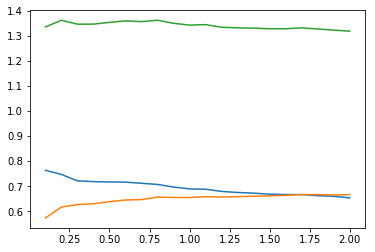

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import svm
from sklearn import tree

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve

matrix_helper = MatrixHelper()

def predict(training_data, training_target, test_data, pen):
    prediction_type = 'SVLinear'
    start = time.time()

    # Create the SVM or DT
    if (prediction_type == 'svm'):
        m = svm.SVC(kernel='linear', C=0.2)
    elif (prediction_type == 'dt'):
        m = tree.DecisionTreeClassifier()
    else:
        m = svm.LinearSVC(C=pen)

    # Fit prediction_type to the model
    m.fit(training_data, training_target)

    # Predict remaining data
    target_prediction = m.predict(test_data)

    end = time.time()
    elapsed = (end - start) / 60
    
    return target_prediction, elapsed
    
# Read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_history.pickle')

feature_matrix = matrices[0]
# feature_matrix = feature_matrix[:1000, :]

rows = matrices[1]
columns = matrices[2]
features_count = feature_matrix.shape[1] - 1

# Create own matrices for vulenrable and not vulnerable entries
vulnerable_matrix, vulnerable_rows = matrix_helper.get_vulnerable_components(feature_matrix, rows)
not_vulnerable_matrix, not_vulnerable_rows = matrix_helper.get_not_vulnerable_components(feature_matrix, rows)


# Split into training sets (2/3) and test sets (1/3)
vulnerable_training, vulnerable_test = matrix_helper.split_training_test(vulnerable_matrix, (2.0/3), vulnerable_rows)
not_vulnerable_training, not_vulnerable_test = matrix_helper.split_training_test(not_vulnerable_matrix, (2.0/3), not_vulnerable_rows)


# Concatenate vulnerable/not-vulnerable
training_matrix = np.concatenate((not_vulnerable_training[0], vulnerable_training[0]), axis=0)
test_matrix = np.concatenate((not_vulnerable_test[0], vulnerable_test[0]), axis=0)
test_rows = not_vulnerable_test[1] + vulnerable_test[1]


# Split into training and target matrices
training_data, training_target = matrix_helper.create_data_target(training_matrix)
test_data, test_target = matrix_helper.create_data_target(test_matrix)

precision_list = []
recall_list = []
c_range = [(i+1)/10.0 for i in range(20)]
# Train the classification model and predict vulnerrabilities for test data
for pen in c_range:
    target_prediction, elapsed_time = predict(training_data, training_target, test_data, pen)
    
    precision, recall, thresholds = precision_recall_curve(test_target, target_prediction)
    precision_list.append(precision[1])
    recall_list.append(recall[1])
    print('|{}|{:^11.3f}|{:^8.3f}| {} |'.format(pen, precision[1], recall[1], elapsed_time))

    
plt.plot(c_range, precision_list)
plt.plot(c_range, recall_list)
plt.plot(c_range, [x + y for x, y in zip(precision_list, recall_list)])

| Type            | Precision | Recall | Time |
|-------------------------------------|-----------|--------|-----------------|
|dt|   0.593   | 0.617  | 1.15047711531 |
|svm|   0.775   | 0.602  | 9.84284751415 |
|linsvm|   0.736   | 0.631  | 0.0606333851814 |